In [17]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns
import ast

import tensorflow as tf

import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


### Reading in Data ###

In [18]:
df = pd.read_csv('final_df.csv')

df['preprocessed_receipt'] = df['preprocessed_receipt'].apply(ast.literal_eval)
df['bio_tags'] = df['bio_tags'].apply(ast.literal_eval)
df['tokenized_receipt'] = df['tokenized_receipt'].apply(ast.literal_eval)

df.head()

,venue_id,receipt_key,receipt_file,tokenized_receipt,preprocessed_receipt,parsed_receipt,bio_tags
0,5531,5531/01/0000000036812256/202003181643-u1584546...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
1,5531,5531/01/0000000036812256/202005150714-u1589519...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
2,5531,5531/01/0000000036812256/202005151410-u1589544...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
3,5531,5531/01/0000000036812256/202005152249-u1589575...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
4,5531,5531/01/0000000036812256/202005180927-u1589786...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]


In [19]:
df = df.dropna()
data = df
data.reset_index(drop=True, inplace=True)
df.head()

,venue_id,receipt_key,receipt_file,tokenized_receipt,preprocessed_receipt,parsed_receipt,bio_tags
0,5531,5531/01/0000000036812256/202007161954-u1594922...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Thee, =>, 2,20], [3, x, Jus, d'Orange,...",Thee x 1 order 220 Notes: _Jus d'Orange x 3 or...,"[[B-QTY, O, B-UNIT, O, B-PRICE], [B-QTY, O, B-..."
1,5531,5531/01/0000000036812256/202007162054-u1594925...,**start** \n--...,"[[**start**], [--paid--], [Table:, 7], [------...","[[2, x, Gregorius, =>, 15,90], [2, x, Grimberg...",Gregorius x 2 order 1590 Notes: _Grimbergen Bl...,"[[B-QTY, O, B-UNIT, O, B-PRICE], [B-QTY, O, B-..."
2,5531,5531/01/0000000036812256/202007162154-u1594929...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Lipton, Ice-Tea, =>, 2,70], [2, x, Sou...",Lipton Ice-Tea x 1 order 270 Notes: _Sourcy Ro...,"[[B-QTY, O, B-UNIT, I-UNIT, O, B-PRICE], [B-QT..."
3,5531,5531/01/0000000036812256/202007162254-u1594932...,**start** \n--...,"[[**start**], [--paid--], [Table:, 7], [------...","[[6, x, Pico, de, Aneto, =>, 25,50], [1, x, Ru...",Pico de Aneto x 6 order 2550 Notes: _Rundvlees...,"[[B-QTY, O, B-UNIT, I-UNIT, I-UNIT, O, B-PRICE..."
4,5531,5531/01/0000000036812256/202007162254-u1594932...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Pinot, Grigio, Torre, Dei, V, =>, 4,50...",Pinot Grigio Torre Dei V x 1 order 450 Notes: ...,"[[B-QTY, O, B-UNIT, I-UNIT, I-UNIT, I-UNIT, I-..."


### Extract labels for Noise tokens ###

In [20]:
def get_new_bio_tags(tokenized_receipt, preprocessed_receipt, bio_tags):
    new_tags = []
    preprocessed_receipt_tuples = [tuple(line) for line in preprocessed_receipt]
    
    tag_dict = dict(zip(preprocessed_receipt_tuples, bio_tags))
    for line in tokenized_receipt:
        line_tuple = tuple(line)
        if line not in preprocessed_receipt:
            line_length = len(line)
            o_line = ['O'] * line_length
            new_tags.append(o_line)
        else:
            new_tags.append(tag_dict[line_tuple])
            
    return new_tags

In [21]:
df['bio_tags'] = df.apply(lambda row: get_new_bio_tags(row['tokenized_receipt'], row['preprocessed_receipt'], row['bio_tags']), axis=1)
df.loc[1234,'tokenized_receipt']

[['**start**'],
 ['--paid--'],
 ['Table:', '1'],
 ['------------------------------------------'],
 ['2', 'x', 'Karmeliet', '=>', '11,00'],
 ['------------------------------------------'],
 ['11,00'],
 ['------------------------------------------'],
 ['Contant', '=>', '11,00'],
 ['------------------------------------------'],
 ['21%', '=>', '1,91'],
 ['------------------------------------------'],
 ['01.08.2020', '16:27'],
 ['**end**'],
 ['V\x01']]

In [22]:
print(df.loc[1244,'bio_tags'])
print(df.loc[1244, 'tokenized_receipt'])

[['O'], ['O'], ['O', 'O'], ['O'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['O'], ['O'], ['O'], ['O', 'O', 'O'], ['O'], ['O', 'O', 'O'], ['O'], ['O', 'O'], ['O'], ['O']]
[['**start**'], ['--paid--'], ['Table:', '5001'], ['------------------------------------------'], ['2', 'x', 'Kornuit', 'Vaas', '=>', '5,20'], ['1', 'x', 'Kornuit', 'Fluit', '=>', '2,30'], ['------------------------------------------'], ['7,50'], ['------------------------------------------'], ['Contant', '=>', '7,50'], ['------------------------------------------'], ['21%', '=>', '1,30'], ['------------------------------------------'], ['01.08.2020', '22:10'], ['**end**'], ['V\x01']]


In [23]:
print(df.loc[8,'tokenized_receipt'])
print(df.loc[8, 'receipt_file'])

[['**start**'], ['--paid--'], ['Table:', '11'], ['------------------------------------------'], ['2', 'x', 'High', 'Beer', '=>', '25,00'], ['1', 'x', 'texels', 'Tap', '=>', '4,50'], ['2', 'x', 'Hapjes', 'High', 'Wine/Beer', '=>', '25,00'], ['1', 'x', 'Twisterfrites', '=>', '4,50'], ['1', 'x', 'Chicken', 'Yakitori', '=>', '8,75'], ['------------------------------------------'], ['67,75'], ['------------------------------------------'], ['PIN', '=>', '42,75'], ['Voucher', '=>', '25,00'], ['------------------------------------------'], ['9%', '=>', '3,16'], ['21%', '=>', '5,12'], ['------------------------------------------'], ['16.07.2020', '22:29'], ['**end**'], ['V\x01']]
**start**                                 
--paid--                                  
Table: 11                                 
------------------------------------------
 2   x High Beer                =>   25,00
 1   x texels Tap               =>    4,50
 2   x Hapjes High Wine/Beer    =>   25,00
 1   x Twisterfrit

In [24]:
train_df = df[df['venue_id'] != 5531]
test_df = df[df['venue_id'] == 5531]

train_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(train_df['tokenized_receipt'], train_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]
test_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(test_df['tokenized_receipt'], test_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]
corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(df['preprocessed_receipt'], df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]

In [25]:

train_df = df[df['venue_id'] != 5531]
test_df = df[df['venue_id'] == 5531]

train_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(train_df['preprocessed_receipt'], train_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]
test_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(test_df['preprocessed_receipt'], test_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]
corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(df['preprocessed_receipt'], df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]


In [26]:
tokens = [token for receipt in df['tokenized_receipt'] for line in receipt for token in line]
words = list(set(tokens))
bio_tags = [tag for receipt in df['bio_tags'] for line in receipt for tag in line]
tags = list(set(bio_tags))
print(tags)

['B-QTY', 'B-UNIT', 'O', 'I-NOTE', 'B-PRICE', 'B-NOTE', 'I-UNIT']


### Data Pre-processing ###

In [27]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {i: w for w, i in tag2idx.items()}

In [28]:
from gensim.models import FastText

word2vec_model = FastText(tokens, vector_size=300, window=5, min_count=1, workers=4)

word2vec_model.save("restaurant_fasttext.model")

In [29]:
hits = 0
misses = 0
embedding_dim = 300

import numpy as np

embedding_matrix = np.zeros((len(word2idx), word2vec_model.vector_size))
for word, i in zip(word2idx.keys(), word2idx.values()):
    embedding_vector = None
    try:
        embedding_vector = word2vec_model.wv[word]
    except KeyError:
        pass

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))


Converted 4819 words (0 misses)


In [30]:
MAX_LEN = 9

In [31]:
X_tr = [[word2idx[w[0]] for w in s] for s in train_corpus]
X_te = [[word2idx[w[0]] for w in s] for s in test_corpus]

X_tr = pad_sequences(maxlen=MAX_LEN, sequences=X_tr, padding="post", value=word2idx["PAD"])
X_te = pad_sequences(maxlen=MAX_LEN, sequences=X_te, padding="post", value=word2idx["PAD"])

y_tr = [[tag2idx[w[1]] for w in s] for s in train_corpus]
y_te = [[tag2idx[w[1]] for w in s] for s in test_corpus]

y_tr = pad_sequences(maxlen=MAX_LEN, sequences=y_tr, padding="post", value=tag2idx["PAD"])
y_te = pad_sequences(maxlen=MAX_LEN, sequences=y_te, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

y_tr = [to_categorical(i, num_classes=len(tags)+1) for i in y_tr]
y_te = [to_categorical(i, num_classes=len(tags)+1) for i in y_te] # n_tags+1(PAD)

# from sklearn.model_selection import train_test_split
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in train_corpus[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in train_corpus[1]]))
print('\n ' )
print('After processing, sample:\n', X_tr[0])
print('\n ' )
print('After processing, labels:\n', y_tr[0])

Raw Sample:
  1

 
Raw Label:
  O

 
After processing, sample:
 [1600    0    0    0    0    0    0    0    0]

 
After processing, labels:
 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((29430, 9), (7788, 9), (29430, 9, 8), (7788, 9, 8))

In [33]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

### Model Training ###

In [34]:
def build_model(max_len = MAX_LEN, input_dim = len(word2idx),embedding_dim = 300):
  input = Input(shape=(max_len,))

  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  output_sequences = Bidirectional(LSTM(units=100,return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=200, return_sequences=True))(output_sequences)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
    
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(8, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy())

  return model

model = build_model()

save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

callbacks = [save_model, es]

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding_layer (Embedding  (None, 9, 300)            1445700   
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 9, 200)            320800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 9, 400)            641600    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 9, 200)            400800    
 onal)                                                       

In [35]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20
459/460 [============================>.] - ETA: 0s - loss: 0.3913
Epoch 1: val_loss improved from inf to 0.15480, saving model to ner_crf.h5
460/460 [==============================] - 29s 50ms/step - loss: 0.3909 - val_loss: 0.1548
Epoch 2/20
459/460 [============================>.] - ETA: 0s - loss: 0.0937
Epoch 2: val_loss improved from 0.15480 to 0.07012, saving model to ner_crf.h5
460/460 [==============================] - 21s 45ms/step - loss: 0.0937 - val_loss: 0.0701
Epoch 3/20
459/460 [============================>.] - ETA: 0s - loss: 0.0428
Epoch 3: val_loss improved from 0.07012 to 0.05010, saving model to ner_crf.h5
460/460 [==============================] - 21s 45ms/step - loss: 0.0428 - val_loss: 0.0501
Epoch 4/20
459/460 [============================>.] - ETA: 0s - loss: 0.0280
Epoch 4: val_loss improved from 0.05010 to 0.04255, saving model to ner_crf.h5
460/460 [==============================] - 21s 46ms/step - loss: 0.0280 - val_loss: 0.0425
Epoch 5/20
459/4

### Results ###

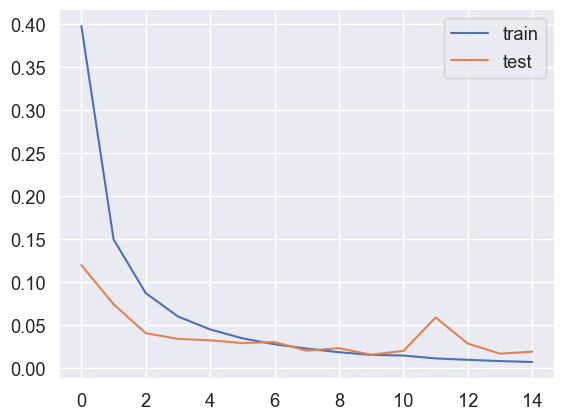

In [169]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

1049/1049 [==============================] - 7s 7ms/step


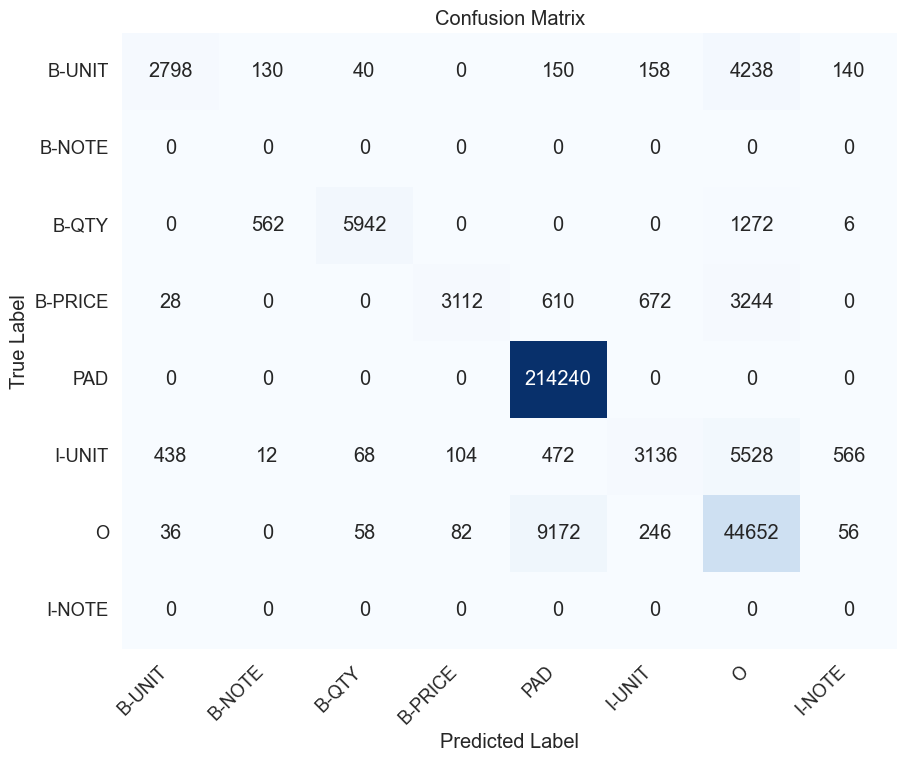

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(X_te)

predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

unique_tags = list(set(flatten_true + flatten_predicted))

cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.show()

In [75]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags, digits=3))

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

      B-UNIT      0.366     0.848     0.511      3300
      B-NOTE      0.000     0.000     0.000       704
       B-QTY      0.764     0.973     0.856      6108
     B-PRICE      0.406     0.944     0.568      3298
         PAD      1.000     0.954     0.976    224644
      I-UNIT      0.304     0.745     0.431      4212
           O      0.822     0.758     0.789     58934
      I-NOTE      0.000     0.000     0.000       768

    accuracy                          0.907    301968
   macro avg      0.458     0.653     0.516    301968
weighted avg      0.933     0.907     0.915    301968



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
